## NI Lab Repository
This notebook was used for exploratory purposes, and is saved as a Colab notebook in https://github.com/networked-intelligence-lab/QM-MVP under:
```
notebooks/pipelines/gameemo_pipeline.ipynb
```

---

## Source
### Code
Besides libraries, code is currently entirely self-written (Dax)

### Dataset
Dataset is sourced from the Biomedical Signal Processing and Control Paper titled "**Database for an emotion recognition system based on EEG signals and various computer games–GAMEEMO**"

*Citation*: Alakus, T. B., Gonen, M., & Turkoglu, I. (2020). Database for an emotion recognition system based on EEG signals and various computer games–GAMEEMO. Biomedical Signal Processing and Control, 60, 101951.

*Kaggle Source*: https://www.kaggle.com/datasets/sigfest/database-for-emotion-recognition-system-gameemo

## Pre-requisite library installs, dataset loading and extraction

In [ ]:
%%sh
apt-get install poppler-utils
pip install pdf2image

Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 33 not upgraded.
Need to get 186 kB of archives.
After this operation, 696 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.3 [186 kB]
Fetched 186 kB in 1s (190 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.3_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.3) ...
Setting up poppler-utils (22.02.0-2ubuntu0.3) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
%%sh
mkdir ~/.kaggle
cp kaggle.json ~/.kaggle/kaggle.json
chmod 600 ~/.kaggle/kaggle.json

In [ ]:
%%sh
kaggle datasets download vitaliykinakh/stable-imagenet1k
unzip /content/database-for-emotion-recognition-system-gameemo.zip

## Initial data processing

In [ ]:
import os
from glob import glob
import shutil
import pathlib
import numpy as np
import pandas as pd
from pdf2image import convert_from_path
from PIL import Image
import json
from keras.layers import Dense, Conv1D, MaxPooling1D, LSTM, Input, concatenate, Reshape
from keras.models import Sequential, Model
from sklearn.model_selection import train_test_split

In [ ]:
try:
  os.makedirs("data")
except FileExistsError:
  pass

In [ ]:
for fileref in pathlib.Path('GAMEEMO/').glob('**/*.csv'):
  fn = str(fileref)
  bn = os.path.basename(fn)
  shutil.copy(fn, f"data/{bn}")

In [ ]:
_set = set()

X = []
X_fns = []
for data_fn in glob("data/*AllChannels.csv"):
  X_fn = os.path.basename(data_fn).split("All")[0]
  data_df = pd.read_csv(data_fn)
  data_df = data_df[[c for c in data_df.columns if "unnamed" not in c.lower()]]
  data_np = np.array(data_df).T
  X.append(data_np)
  X_fns.append(X_fn)

In [ ]:
X = np.array(X)

In [ ]:
print(X.shape)

(112, 14, 38252)


In [ ]:
print(sorted(X_fns))

['S01G1', 'S01G2', 'S01G3', 'S01G4', 'S02G1', 'S02G2', 'S02G3', 'S02G4', 'S03G1', 'S03G2', 'S03G3', 'S03G4', 'S04G1', 'S04G2', 'S04G3', 'S04G4', 'S05G1', 'S05G2', 'S05G3', 'S05G4', 'S06G1', 'S06G2', 'S06G3', 'S06G4', 'S07G1', 'S07G2', 'S07G3', 'S07G4', 'S08G1', 'S08G2', 'S08G3', 'S08G4', 'S09G1', 'S09G2', 'S09G3', 'S09G4', 'S10G1', 'S10G2', 'S10G3', 'S10G4', 'S11G1', 'S11G2', 'S11G3', 'S11G4', 'S12G1', 'S12G2', 'S12G3', 'S12G4', 'S13G1', 'S13G2', 'S13G3', 'S13G4', 'S14G1', 'S14G2', 'S14G3', 'S14G4', 'S15G1', 'S15G2', 'S15G3', 'S15G4', 'S16G1', 'S16G2', 'S16G3', 'S16G4', 'S17G1', 'S17G2', 'S17G3', 'S17G4', 'S18G1', 'S18G2', 'S18G3', 'S18G4', 'S19G1', 'S19G2', 'S19G3', 'S19G4', 'S20G1', 'S20G2', 'S20G3', 'S20G4', 'S21G1', 'S21G2', 'S21G3', 'S21G4', 'S22G1', 'S22G2', 'S22G3', 'S22G4', 'S23G1', 'S23G2', 'S23G3', 'S23G4', 'S24G1', 'S24G2', 'S24G3', 'S24G4', 'S25G1', 'S25G2', 'S25G3', 'S25G4', 'S26G1', 'S26G2', 'S26G3', 'S26G4', 'S27G1', 'S27G2', 'S27G3', 'S27G4', 'S28G1', 'S28G2', 'S28G3', 

## Manual label curation pipeline

In [ ]:
pdfs = sorted(glob("GAMEEMO/**/*.pdf", recursive=True)) # The following cells is to circumvent input() after display() bugs

In [ ]:
count = 0
labels_dict = {}

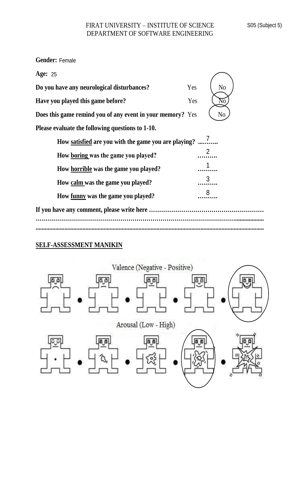

In [ ]:
pdf_fn = pdfs[count]
label_key = pdf_fn
for rem_text in ["GAMEEMO/(", ")/SAM Ratings/", ".pdf"]:
  label_key = label_key.replace(rem_text, '')
images = convert_from_path(pdf_fn)
im = images[0].resize((300, 500))
display(im)

In [ ]:
user_input = input()
labels_dict[label_key] = user_input
count += 1

7 2 1 3 8 5 4


In [ ]:
print(labels_dict)

{'S01G1': '2 8 1 3 2 1.5 2', 'S01G2': '7 2 1 8 8 3 2.5', 'S01G3': '2 2 8 1 1 1.5 5', 'S01G4': '8 1 1 3 9 3 4.5', 'S02G1': '1 8 1 4 2 1 1', 'S02G2': '5 2 1 7 6 3 3', 'S02G3': '2 2 8 3 2 1 5', 'S02G4': '8 2 2 7 9 4 3', 'S03G1': '2 7 2 6 1 1 1.5'}


In [ ]:
print(json.dumps(labels_dict, sort_keys=True, indent=4))

{
    "S01G1": "2 8 1 3 2 1.5 2",
    "S01G2": "7 2 1 8 8 3 2.5",
    "S01G3": "2 2 8 1 1 1.5 5",
    "S01G4": "8 1 1 3 9 3 4.5",
    "S02G1": "1 8 1 4 2 1 1",
    "S02G2": "5 2 1 7 6 3 3",
    "S02G3": "2 2 8 3 2 1 5",
    "S02G4": "8 2 2 7 9 4 3",
    "S03G1": "2 7 2 6 1 1 1.5",
    "S03G2": "8 1 1 8 8 4 3",
    "S03G3": "9 1 10 1 1 1.5 5",
    "S03G4": "9 1 1 3 9 5 3.5",
    "S04G1": "4 8 1 3 1 1.5 2.5",
    "S04G2": "7 3 1 9 6 4.5 4",
    "S04G3": "7 1 9 2 1 2 5",
    "S04G4": "8 1 1 3 9 3.5 4",
    "S05G1": "3 7 1 2 1 2 2",
    "S05G2": "8 2 1 5 7 5 5",
    "S05G3": "4 1 8 1 2 1 5",
    "S05G4": "7 2 1 3 8 5 4"
}


## Start of preprocessing and NN

In [ ]:
labels_dict = {
    "S01G1": "2 8 1 3 2 1.5 2",
    "S01G2": "7 2 1 8 8 3 2.5",
    "S01G3": "2 2 8 1 1 1.5 5",
    "S01G4": "8 1 1 3 9 3 4.5",
    "S02G1": "1 8 1 4 2 1 1",
    "S02G2": "5 2 1 7 6 3 3",
    "S02G3": "2 2 8 3 2 1 5",
    "S02G4": "8 2 2 7 9 4 3",
    "S03G1": "2 7 2 6 1 1 1.5",
    "S03G2": "8 1 1 8 8 4 3",
    "S03G3": "9 1 10 1 1 1.5 5",
    "S03G4": "9 1 1 3 9 5 3.5",
    "S04G1": "4 8 1 3 1 1.5 2.5",
    "S04G2": "7 3 1 9 6 4.5 4",
    "S04G3": "7 1 9 2 1 2 5",
    "S04G4": "8 1 1 3 9 3.5 4",
    "S05G1": "3 7 1 2 1 2 2",
    "S05G2": "8 2 1 5 7 5 5",
    "S05G3": "4 1 8 1 2 1 5",
    "S05G4": "7 2 1 3 8 5 4"
}

In [ ]:
y = []
for k, v in labels_dict.items():
  y.append([float(_v) for _v in v.split(' ')])

In [ ]:
X_train = X[:len(y)]
y_train = np.array(y)

In [ ]:
n_samples, n_channels, n_features = X_train.shape
channel_inputs = [Input(shape=(n_features,), name=f"input_{i}") for i in range(n_channels)]

channel_pipelines = []
for channel_input in channel_inputs:
  x = Reshape((n_features // 73, 73))(channel_input)
  x = LSTM(256)(x)
  x = Dense(128)(x)
  channel_pipelines.append(x)

concatenated = concatenate(channel_pipelines)
x = Dense(256, activation="relu")(concatenated)
output = Dense(7, activation="softmax")(x)

model = Model(inputs=channel_inputs, outputs=output)

In [ ]:
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_0 (InputLayer)        [(None, 38252)]              0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 38252)]              0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 38252)]              0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 38252)]              0         []                            
                                                                                              

In [ ]:
X_train_reshaped = [X_train[:, i, :] for i in range(n_channels)]
model.fit(X_train_reshaped, y_train, batch_size=16, epochs=25)

Epoch 1/25
2/2 [==============================] - 1s 226ms/step - loss: 19.8467
Epoch 2/25
2/2 [==============================] - 0s 225ms/step - loss: 19.8448
Epoch 3/25
2/2 [==============================] - 0s 228ms/step - loss: 19.8459
Epoch 4/25
2/2 [==============================] - 0s 227ms/step - loss: 19.8467
Epoch 5/25
2/2 [==============================] - 0s 226ms/step - loss: 19.8458
Epoch 6/25
2/2 [==============================] - 0s 225ms/step - loss: 19.8447
Epoch 7/25
2/2 [==============================] - 0s 225ms/step - loss: 19.8447
Epoch 8/25
2/2 [==============================] - 0s 225ms/step - loss: 19.8447
Epoch 9/25
2/2 [==============================] - 0s 226ms/step - loss: 19.8447
Epoch 10/25
2/2 [==============================] - 0s 226ms/step - loss: 19.8447
Epoch 11/25
2/2 [==============================] - 0s 226ms/step - loss: 19.8447
Epoch 12/25
2/2 [==============================] - 0s 227ms/step - loss: 19.8447
Epoch 13/25
2/2 [====================

## Inference

In [ ]:
sample = X_train[1, :, :]
sample_reshaped = [np.expand_dims(sample[i, :], axis=0) for i in range(n_channels)]

pred = model.predict(sample_reshaped)

1/1 [==============================] - 0s 116ms/step


In [ ]:
inference_mappings = ["satisfied", "boring", "horrible", "calm", "funny", "positive", "intense"]

top_k = sorted(zip(inference_mappings, pred[0]), key=lambda x: x[1], reverse=True)[:3]
top_emotions = [k[0] for k in top_k]
music_prompt = f"Generate music that exemplifies the emotions of {', '.join(top_emotions[:-1])}, and {top_emotions[-1]}"

In [ ]:
print(music_prompt)

Generate music that exemplifies the emotions of calm, funny, and positive


# MLM Part

In [ ]:
%%sh
pip install selenium undetected-chromedriver python-dotenv requests seleniumbase

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 551.2/551.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.0/116.0 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 67.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.0/334.0 kB 41.4 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
  Attempting uninstall: pytest
    Found existing installation: pytest 7.4.4
    Uninstalling p

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [ ]:
%%sh
apt install chromium-chromedriver

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  apparmor chromium-browser libfuse3-3 liblzo2-2 libudev1 snapd squashfs-tools systemd-hwe-hwdb
  udev
Suggested packages:
  apparmor-profiles-extra apparmor-utils fuse3 zenity | kdialog
The following NEW packages will be installed:
  apparmor chromium-browser chromium-chromedriver libfuse3-3 liblzo2-2 snapd squashfs-tools
  systemd-hwe-hwdb udev
The following packages will be upgraded:
  libudev1
1 upgraded, 9 newly installed, 0 to remove and 32 not upgraded.
Need to get 26.4 MB of archives.
After this operation, 116 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 apparmor amd64 3.0.4-2ubuntu2.3 [595 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 liblzo2-2 amd64 2.10-2build3 [53.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 squashfs-tools amd64 1:4.5-3build1 [159 kB]

In [ ]:
%%sh
git clone https://github.com/armintum/MusicLM.git

fatal: destination path 'MusicLM' already exists and is not an empty directory.


CalledProcessError: Command 'b'git clone https://github.com/armintum/MusicLM.git\n'' returned non-zero exit status 128.

In [ ]:
from MusicLM.MusicLM import Music

# Soft-fix given dotenv not working
os.environ["EMAIL"] = input("Email")
os.environ["PASSWORD"] = input("Password")
os.environ["TOKEN"] = ""

music = Music()
input = "Ambient, soft sounding music I can study to"
tracks = music.get_tracks(input, 2)

if isinstance(tracks, list):
    music.b64toMP3(tracks, input)


WebDriverException: Message: unknown error: cannot connect to chrome at 127.0.0.1:9222
from chrome not reachable
Stacktrace:
#0 0x5855a397bd93 <unknown>
#1 0x5855a365f177 <unknown>
#2 0x5855a364a02a <unknown>
#3 0x5855a3698cf8 <unknown>
#4 0x5855a368f1cb <unknown>
#5 0x5855a36d9b7c <unknown>
#6 0x5855a36cd1e3 <unknown>
#7 0x5855a369d135 <unknown>
#8 0x5855a369e13e <unknown>
#9 0x5855a393fe4b <unknown>
#10 0x5855a3943dfa <unknown>
#11 0x5855a392c6d5 <unknown>
#12 0x5855a3944a6f <unknown>
#13 0x5855a391069f <unknown>
#14 0x5855a3969098 <unknown>
#15 0x5855a3969262 <unknown>
#16 0x5855a397af34 <unknown>
#17 0x7c4f8097dac3 <unknown>
